Potential outcomes: theory and application

Sources:
- causal inference mixtape 
- Imbens book 
- Imbens review article JEL
- Dehejia/Wahba 2002. https://business.baylor.edu/scott_cunningham/teaching/dehejia-and-wahba-2002.pdf

I slightly adjusted the comparisons what made most sense for me in the present context but have not compared them all to the original sources.
Specifically, I tried to approximate as closely as possible a real situation where we do not have the experimental controls.

Context
- explain Dehejia/Wahba; Lalonde predecessor

In [92]:
import numpy as np 
import pandas as pd 
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
from itertools import combinations 
import plotnine as p

# read data
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
def read_data(file): 
    return pd.read_stata("https://github.com/scunning1975/mixtape/raw/master/" + file)



### Load data 

In [93]:
nsw_dw = read_data('nsw_mixtape.dta')
nsw_dw_cpscontrol = read_data('cps_mixtape.dta')




In [94]:
nsw_dw.describe()

,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78
count,445.000000,445.000000,445.000000,445.000000,445.00000,445.000000,445.000000,445.000000,445.000000,445.000000
mean,0.415730,25.370787,10.195505,0.833708,0.08764,0.168539,0.782022,2102.265381,1377.138306,5300.764160
std,0.493402,7.100282,1.792119,0.372762,0.28309,0.374766,0.413337,5363.582520,3150.960693,6631.491699
min,0.000000,17.000000,3.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,24.000000,10.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,3701.812012
75%,1.000000,28.000000,11.000000,1.000000,0.00000,0.000000,1.000000,824.388916,1220.836060,8124.714844
max,1.000000,55.000000,16.000000,1.000000,1.00000,1.000000,1.000000,39570.679688,25142.240234,60307.929688


Stack together; prepare more variables

In [95]:
# for differentiating groups later 
nsw_dw["random"] = 1 
nsw_dw_cpscontrol["random"] = 0

nsw_stacked = pd.concat((nsw_dw_cpscontrol, nsw_dw))

# unemployment 
nsw_stacked[["unemp74", "unemp75"]] = 0
nsw_stacked.loc[nsw_stacked.re74==0, 'unemp74'] = 1
nsw_stacked.loc[nsw_stacked.re75==0, 'unemp75'] = 1

# rename earnings
nsw_stacked = nsw_stacked.rename(columns={"re74": "earn74", "re75": "earn75", "re78": "earn78"})

In [96]:
nsw_stacked.describe()

,treat,age,educ,black,hisp,marr,nodegree,earn74,earn75,earn78,random,unemp74,unemp75
count,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000
mean,0.011255,33.012592,11.977916,0.094117,0.072458,0.697025,0.308998,13694.237305,13318.517578,14588.224609,0.027073,0.136217,0.123928
std,0.105495,11.030899,2.862478,0.292000,0.259253,0.459558,0.462094,9675.637695,9372.831055,9702.608398,0.162301,0.343029,0.329509
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,24.000000,11.000000,0.000000,0.000000,0.000000,0.000000,3644.236084,3695.896973,5088.759766,0.000000,0.000000,0.000000
50%,0.000000,31.000000,12.000000,0.000000,0.000000,1.000000,0.000000,14655.320312,14109.530273,15962.400391,0.000000,0.000000,0.000000
75%,0.000000,42.000000,13.000000,0.000000,0.000000,1.000000,1.000000,23360.339844,22703.080078,25564.669922,0.000000,0.000000,0.000000
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,39570.679688,25243.550781,60307.929688,1.000000,1.000000,1.000000


### Naive difference in means

- we take the treated from `nsw_dw` and the controls from `nsw_dw_cpscontrol` (ignore the controls from the experiment)

In [97]:
mask_treat = (nsw_stacked["treat"] == 1) & (nsw_stacked["random"] == 1)
mask_control = (nsw_stacked["treat"] == 0) & (nsw_stacked["random"] == 0)

yvar = "earn78"
y1 = nsw_stacked.loc[mask_treat, yvar].mean()
y0 = nsw_stacked.loc[mask_control, yvar].mean()

te1 = y1 - y0


print(f"The non-experimental difference in raw means is {te1:.2f}")

The non-experimental difference in raw means is -8497.52


This number is the same as in Dehejia/Wahba 2022, table 2, row 2, second-last column

### Experimental estimate

We *do* have the experimental data, so let's see the estimate here.

In [98]:
mask_treat = (nsw_stacked["treat"] == 1) & (nsw_stacked["random"] == 1)
mask_control = (nsw_stacked["treat"] == 0) & (nsw_stacked["random"] == 1)

yvar = "earn78"
y1 = nsw_stacked.loc[mask_treat, yvar].mean()
y0 = nsw_stacked.loc[mask_control, yvar].mean()

te1 = y1 - y0


print(f"The experimental difference in raw means is {te1:.2f}")

The experimental difference in raw means is 1794.34


### Sample selection

- discuss the formula/decomposition 
- we *could* run a regression and control for the other observed characteristics. 
- but for illustration, we won't run any regression and try to adjust for these differences otherwise
- discuss balance?

### Propensity score

- discuss the theorem 
- for discussing balance here, we'd need to match on closest neighbor 

In [99]:
# we'll ignore the experimental controls from now on.
drop = (nsw_stacked["random"] == 1) & (nsw_stacked["treat"] == 0)
nsw_stacked = nsw_stacked.loc[~drop, :]

mask_treat = nsw_stacked["treat"] == 1
mask_control = nsw_stacked["treat"] == 0

N_treat = nsw_stacked.loc[mask_treat, :].shape[0]
N_control = nsw_stacked.loc[mask_control, :].shape[0]

assert N_treat + N_control == nsw_stacked.shape[0], "some units got lost"

In [100]:
# estimating propensity score
logit_nsw = smf.glm(formula="""treat ~ age + age**2 + age**3 + educ + educ**2 + 
                    marr + nodegree + black + hisp + earn74 + earn75 + unemp74 + unemp75 + educ*earn74""", 
                    family=sm.families.Binomial(),
                   data=nsw_stacked).fit()
                  
nsw_stacked['pscore'] = logit_nsw.predict(nsw_stacked)

In [101]:
nsw_stacked["pscore"].describe()

count    16177.000000
mean         0.011436
std          0.059767
min          0.000005
25%          0.000054
50%          0.000215
75%          0.001770
max          0.636450
Name: pscore, dtype: float64

In [105]:
import matplotlib.pyplot as plt 


In [118]:

def make_hist(df, input_map, xlabel="Value"):
    "Make a histogram of df, mapping over inputs in `input_map`."
    plt.figure(figsize=(6, 4))
    plt.title("Histogram of propensity score")
    plt.xlabel(xlabel)
    plt.ylabel("Density")
    plt.grid(True)

    for label, params in input_map.items():
        x = df.loc[params["mask"], "pscore"]
        # Create histograms for each group
        plt.hist(x, bins=20, density=True, alpha=0.7, color=params["color"], label=label)

        # Add legend
        plt.legend()

    # Display the plot
    plt.show()




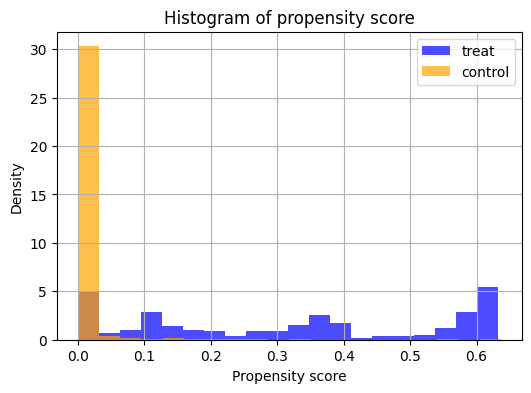

In [120]:
plot_map = {
    "treat": {
        "mask": mask_treat,
        "color": "blue"
    },
    "control": {
        "mask": mask_control,
        "color": "orange"
    }
}

make_hist(nsw_stacked, plot_map, "Propensity score")

So we have this huge imbalance. How can we fix it? 

do we even need the reweighting? or go straight to nearest-neighbor matching? why is re-weighting useful? 

also, can we use the ATE from the experiment with the matched estimator to illustrate the difference between the ATE and the ATT? does it not also matter what the population is we are referring to? ie, in the experiment, the ATE are the experimental units. in the matched estimate, the population is the universe of CPS respondents.

old stuff from Cunningham directly

In [2]:

nsw_dw = read_data('nsw_mixtape.dta')

mean1 = nsw_dw[nsw_dw.treat==1].re78.mean()
mean0 = nsw_dw[nsw_dw.treat==0].re78.mean()
ate = np.unique(mean1 - mean0)[0]
print("The experimental ATE estimate is {:.2f}".format(ate))

The experimental ATE estimate is 1794.34


In [3]:


# Prepare data for logit 
nsw_dw_cpscontrol = read_data('cps_mixtape.dta')

nsw_dw_cpscontrol = pd.concat((nsw_dw_cpscontrol, nsw_dw))
nsw_dw_cpscontrol[['u74', 'u75']] = 0
nsw_dw_cpscontrol.loc[nsw_dw_cpscontrol.re74==0, 'u74'] = 1
nsw_dw_cpscontrol.loc[nsw_dw_cpscontrol.re75==0, 'u75'] = 1
# estimating propensity score
logit_nsw = smf.glm(formula="""treat ~ age + age**2 + age**3 + educ + educ**2 + 
                    marr + nodegree + black + hisp + re74 + re75 + u74 + u75 + educ*re74""", 
                    family=sm.families.Binomial(),
                   data=nsw_dw_cpscontrol).fit()
                  
nsw_dw_cpscontrol['pscore'] = logit_nsw.predict(nsw_dw_cpscontrol)


# continuation
N = nsw_dw_cpscontrol.shape[0]

# Manual with non-normalized weights using all data
nsw_dw_cpscontrol = nsw_dw_cpscontrol 
nsw_dw_cpscontrol['d1'] = nsw_dw_cpscontrol.treat/nsw_dw_cpscontrol.pscore
nsw_dw_cpscontrol['d0'] = (1-nsw_dw_cpscontrol.treat)/(1-nsw_dw_cpscontrol.pscore)


s1 = nsw_dw_cpscontrol.d1.sum()
s0 = nsw_dw_cpscontrol.d0.sum()

nsw_dw_cpscontrol['y1'] = nsw_dw_cpscontrol.treat * nsw_dw_cpscontrol.re78 / nsw_dw_cpscontrol.pscore
nsw_dw_cpscontrol['y0'] = (1 - nsw_dw_cpscontrol.treat) * nsw_dw_cpscontrol.re78 / (1 - nsw_dw_cpscontrol.pscore)
nsw_dw_cpscontrol['ht'] = nsw_dw_cpscontrol['y1'] - nsw_dw_cpscontrol['y0']

te_1 = nsw_dw_cpscontrol.ht.mean()

print("Treatment Effect (non-normalized, all data): {:.2f}".format(te_1))
        

nsw_dw_cpscontrol['y1'] = nsw_dw_cpscontrol.treat * nsw_dw_cpscontrol.re78 / nsw_dw_cpscontrol.pscore
nsw_dw_cpscontrol['y1'] /= s1/N
nsw_dw_cpscontrol['y0'] = (1 - nsw_dw_cpscontrol.treat) * nsw_dw_cpscontrol.re78 / (1 - nsw_dw_cpscontrol.pscore)
nsw_dw_cpscontrol['y0'] /= s0/N
nsw_dw_cpscontrol['ht'] = nsw_dw_cpscontrol['y1'] - nsw_dw_cpscontrol['y0']

te_2 = nsw_dw_cpscontrol.ht.mean()

print("Treatment Effect (normalized, all data): {:.2f}".format(te_2))
        


nsw_dw_trimmed = nsw_dw_cpscontrol.drop(['d1', 'd0', 'y1', 'y0'], axis=1)
nsw_dw_trimmed = nsw_dw_trimmed[nsw_dw_trimmed.pscore.between(.1, .9)]
N = nsw_dw_trimmed.shape[0]

nsw_dw_trimmed['y1'] = nsw_dw_trimmed.treat * nsw_dw_trimmed.re78 / nsw_dw_trimmed.pscore
nsw_dw_trimmed['y0'] = (1 - nsw_dw_trimmed.treat) * nsw_dw_trimmed.re78 / (1 - nsw_dw_trimmed.pscore)
nsw_dw_trimmed['ht'] = nsw_dw_trimmed['y1'] - nsw_dw_trimmed['y0']

te_3 = nsw_dw_trimmed.ht.mean()

print("Treatment Effect (non-normalized, trimmed data): {:.2f}".format(te_3))



nsw_dw_trimmed['y1'] = nsw_dw_trimmed.treat * nsw_dw_trimmed.re78 / nsw_dw_trimmed.pscore
nsw_dw_trimmed['y1'] /= s1/N
nsw_dw_trimmed['y0'] = (1 - nsw_dw_trimmed.treat) * nsw_dw_trimmed.re78 / (1 - nsw_dw_trimmed.pscore)
nsw_dw_trimmed['y0'] /= s0/N
nsw_dw_trimmed['ht'] = nsw_dw_trimmed['y1'] - nsw_dw_trimmed['y0']

te_4 = nsw_dw_trimmed.ht.mean()

print("Treatment Effect (normalized, trimmed data): {:.2f}".format(te_4))

Treatment Effect (non-normalized, all data): -11535.55
Treatment Effect (normalized, all data): -7044.80
Treatment Effect (non-normalized, trimmed data): 2486.22
Treatment Effect (normalized, trimmed data): 423.62
